<a href="https://colab.research.google.com/github/alreylz/GuitarBassClassificationCNN/blob/master/Bass%26Guitar_Convolutional_Net_coredamnwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>RED NEURONAL CONVOLUCIONAL DE CLASIFICACIÓN DE IMÁGENES EN BAJOS Y GUITARRAS</h1>
<h2>CONVOLUTIONAL NEURAL NETWORK CLASSIFYING BASS AND GUITARS</h2>


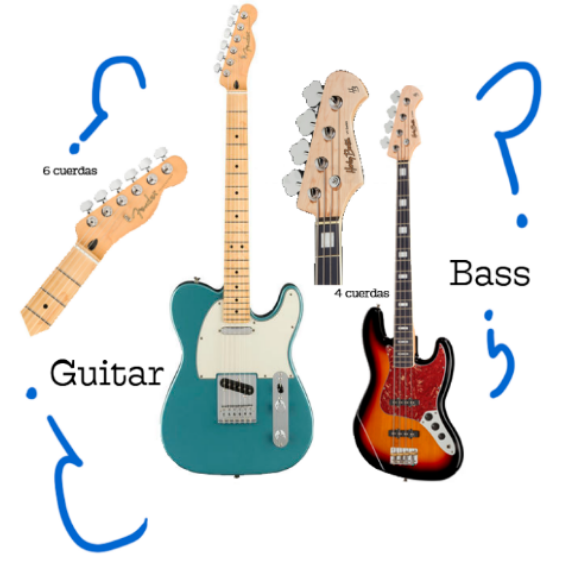




**NOTA: Asegurarse de elegir un "Entorno de ejecución" con Python 3 y GPU (en el menú superior)**

Permisos de acceso a archivos de Google Drive, para trabajar en la nube.

In [1]:
# Permitimos el acceso de Colab a nuestra cuenta de drive
# Seguramente nos pida permisos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-procesado: adaptado de imágenes para usar como entrada del modelo

In [ ]:
##################
#IMPORT RESOURCES:
##################

import os #Librería para moverse en los ficheros de Colab
!pip3 install Pillow #Librería para manipulación de imágenes

from IPython.display import display # Mostrar imágenes en Colab
from PIL import Image #permite abrir y manipular imágenes

import time # Para medir tiempos de ejecución

from numpy import asarray
import numpy as np
import csv
import time
import pandas as pd
from sklearn.utils import shuffle #barajado de datos del dataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import matplotlib.pyplot as pl
import matplotlib.image as mpimg
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import math

import datetime
#ver lo que ocupa algo en memoria
import sys

## Iteración sobre todo el conjunto de imágenes de guitarras y bajos (visualización y conteo)

In [ ]:
#########################################
#ITERACIÓN SOBRE EL CONJUNTO DE IMÁGENES
#########################################
datasetPath = "drive/My Drive/Colab Notebooks/PA-Dataset"

bassPathList = []
guitarPathList = []

#Subcarpetas de thumbnails
fullPathGuitarImgs = f"{datasetPath}/Guitarras/thumbnail/"
fullPathBassImgs = f"{datasetPath}/Bajos/thumbnail/"

#SET THIS TO TRUE TO DISPLAY ALL THE IMAGES AS THEY ARE EXPLORED
displayAll = False

startT = time.time()

print("----------")
print("|          \\")
print("|            -----")
print("| GUITAR PICS    |")
print("|________________|")
for filename in os.listdir(fullPathGuitarImgs):
  if(filename.endswith("jpg")):
    fileImg = Image.open(f"{fullPathGuitarImgs}{filename}")
    if(displayAll):
      display(fileImg)
    print(f"\t\t |--> {filename} | Format:{fileImg.format}| Size:{fileImg.size} |  Mode:{fileImg.mode}")
    guitarPathList.append(filename)

print("----------")
print("|          \\")
print("|            -----")
print("| BASS PICS      |")
print("|________________|")
for filename in os.listdir(fullPathBassImgs):
  if(filename.endswith("jpg")):
    fileImg = Image.open(f"{fullPathBassImgs}{filename}")
    if(displayAll):
      display(fileImg)
    print(f"\t\t{filename} | Format:{fileImg.format}| Size:{fileImg.size} |  Mode:{fileImg.mode}")
    bassPathList.append(filename)


print(f"Number of guitars = {guitarPathList.shape}")
print(f"Number of bass ={bassPathList.shape}")

endT = time.time()
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print(f"Elapsed time (t) in this Notebook Cell: {endT - startT}s")
print("---------------------------------------------------------")

Streaming output truncated to the last 5000 lines.
		 |--> Guitar3930.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3931.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3932.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3933.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3934.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3935.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3936.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3937.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3938.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3939.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3940.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3941.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3942.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3943.jpg | Format:JPEG| Size:(150, 150) |  Mode:RGB
		 |--> Guitar3944.jpg | 

AttributeError: ignored

## Pasos de preprocesado

---



a) Construcción de numpy arrays persistentes que representan el dataset completo
- *guitarAndBassNpy*: numpy array de 4 dimensiones (Nº imagen, Height, Width, Channel)
- *labelsNpy*: numpy array de 1 dimensión que contiene un entero que representa la clase asociada a cada imagen

b) Shuffling de las imágenes, para evitar seleccionar todo guitarras o todo bajos en distintos conjuntos de entrenamiento, validación y test.

c) Guardado de arrays de numpy a archivo para carga rápida del dataset.

d) Definición de subconjuntos

e) Creación de tensores con formato adecuado para input del modelo (permutación necesaria de dimensiones)


In [ ]:

##################################
# IMÁGENES Y LABES A NUMPY ARRAYS
##################################

guitarAndBassNpy = np.empty(0)
labelsNpy = np.empty(0)

displayProgressEvery = 100

guitarCount = 0
bassCount = 0
imgCount = 0
progressCounter = 0

startT = time.time()
print("************************")
print("*DATASET TO NUMPY*******")
print("************************")

#Recorremos imágenes de guitarras y bajos existentes
for root_,dirs_,file_ in os.walk("drive/My Drive/Colab Notebooks/PA-Dataset"):
  for name in file_:
    if(".jpg" in name):
      pathToBassOrGuitarImg = os.path.join(root_,name) #-> Path completa al archivo de imagen
      #print(f"File found:\n {pathToBassOrGuitarImg}")
      l_image = Image.open(pathToBassOrGuitarImg)

      if("Guitar" in pathToBassOrGuitarImg):
        labelToAppend = 0
        guitarCount+=1

        if(imgCount == 0): #Creo array base
          guitarAndBassNpy = np.expand_dims(np.asarray(l_image), axis=0) #-> Array con (Nimages,150,150,3)
          #Inicialización de array de labels
          labelsNpy = np.empty(0) #Reiniciar array
          labelsNpy = np.append(labelsNpy, labelToAppend) #Añado al final la nueva label.
        else:
          guitarAndBassNpy = np.append(guitarAndBassNpy , np.expand_dims(np.asarray(l_image), axis=0), axis=0)
          #Actualización de array de labels
          labelsNpy = np.append(labelsNpy, labelToAppend) #Añado al final la nueva label.

        progressCounter+=1
        progressCounter%=displayProgressEvery

      elif("Bass" in pathToBassOrGuitarImg):
        bassCount+=1
        labelToAppend = 1
        if(imgCount == 0): #Creo array base
          guitarAndBassNpy = np.expand_dims(np.asarray(l_image), axis=0) #-> Array con (Nimages,150,150,3)
          #Inicialización de array de labels
          labelsNpy = np.empty(0) #Reiniciar array
          labelsNpy = np.append(labelsNpy, labelToAppend) #Añado al final la nueva label.
        else:
          guitarAndBassNpy = np.append(guitarAndBassNpy , np.expand_dims(np.asarray(l_image), axis=0), axis=0)
          #Actualización de array de labels
          labelsNpy = np.append(labelsNpy, labelToAppend) #Añado al final la nueva label.

        progressCounter+=1
        progressCounter%=displayProgressEvery

      if(progressCounter == 0):
        print(f"DONE WITH:\n \t{guitarCount}/6924 guitars \n \t{bassCount}/1076 bass ")

      imgCount+=1

endT = time.time()

print(f"Tiempo de carga del dataset to numpy: {endT-startT}s = {(endT-starT)/60}min")

In [ ]:
#@title **[Persistencia de archivos]** Define aquí los nombres para los archivos de salida que encapsulan todo el dataset (imágenes y etiquetas)
#@markdown Se guardará en "drive/My Drive/Colab Notebooks/PA-Dataset/<nombre>.npy"
DS_ImgsFilename = "ThomannX" #@param {type:"string"}
DS_LabelsFilename = "ThomannY" #@param {type:"string"}

In [ ]:
##################################
# BARAJADO DE DATASET EN NUMPY ARR
#   + GUARDADO EN ARCHIVO
##################################
startT = time.time()

print("************************")
print("*SHUFFLING DE DATASET***")
print("************************")

guitarAndBassNpy, labelsNpy = shuffle(guitarAndBassNpy, labelsNpy, random_state=0)
print(f"\tguitarAndBassNpy.shape should be (8000,150,150,3) : {guitarAndBassNpy.shape}")
print(f"\tlabelsNpy.shape should be (8000) : {labelsNpy.shape}")


#np.save("drive/My Drive/Colab Notebooks/PA-Dataset/ThomannX.npy",guitarAndBassNpy)
#np.save("drive/My Drive/Colab Notebooks/PA-Dataset/ThomannY.npy",labelsNpy)

np.save(f"drive/My Drive/Colab Notebooks/PA-Dataset/{DS_ImgsFilename}.npy",guitarAndBassNpy)
np.save(f"drive/My Drive/Colab Notebooks/PA-Dataset/{DS_LabelsFilename}.npy",labelsNpy)


endT = time.time()

print(f"Tiempo de shuffling to numpy: {endT-startT} s = {(endT-startT)/60}")

print("************************")
print("*------FINISHED--------*")
print("************************")

print(f"#GUITARRAS = {guitarCount}")
print(f"#BAJOS = {bassCount}")

In [ ]:
#@title [**Carga de datos**] Selecciona un dataset (imágenes y etiquetas)
#@markdown Introduce el nombre de un dataset en "drive/My Drive/Colab Notebooks/PA-Dataset/<nombre>.npy"
DS_ImgsFilename = "ThomannX" #@param {type:"string"}
DS_LabelsFilename = "ThomannY" #@param {type:"string"}

In [ ]:
##################################
# CARGA DEL DATASET DESDE ARCHIVO
##################################

startT = time.time()
print("Cargando dataset desde archivo npy...")
#guitarAndBassNpy = np.load("drive/My Drive/Colab Notebooks/PA-Dataset/ThomannX.npy")
guitarAndBassNpy = np.load(f"drive/My Drive/Colab Notebooks/PA-Dataset/{DS_ImgsFilename}.npy")

print(f"\tObtained a numpy array with shape: {guitarAndBassNpy.shape}")
#labelsNpy = np.load("drive/My Drive/Colab Notebooks/PA-Dataset/ThomannY.npy")
labelsNpy = np.load(f"drive/My Drive/Colab Notebooks/PA-Dataset/{DS_LabelsFilename}.npy")

print(f"\tObtained a numpy array with shape:{labelsNpy.shape}")
endT = time.time()

print(f"Tiempo de carga de dataset desde npy: {endT-startT} s = {(endT-startT)/60}")

In [ ]:
def subset_Size_Definitions(ds_npy ,train_frac = 3/4, val_train_frac=1/4, side_fx= True ):

  #Número de imágenes a procesar en total, las cuales queremos asignar a tres subconjuntos:
  # Training
  # Validation
  # Testing
  nData = ds_npy.shape[0]

  #N datos para entrenamiento (e.g. 3/4)
  nData_training = int(nData*train_frac)
  # y el 1/4 restante, para testing (1/4)
  nData_testing = nData - nData_training

  # De los datos reservados para entrenamiento, cogemos val_train_frac para validación,
  # fracción solo utilizada en validación
  nData_validation = int(nData_training*val_train_frac)
  nData_training = nData_training - nData_validation

  samplePercent_training = int(nData_training/nData*100.0)
  samplePercent_validation = int(nData_validation/nData*100.0)
  samplePercent_testing = int(nData_testing/nData*100.0)
  #print(f"NUMBER OF ROWS in Dataset =  {nData} ")
  #print(f"\tN_training ({samplePercent_training}%) = {nData_training} samples \n", f"\tN_validation ({samplePercent_validation}%) = {nData_validation} samples\n", f"\tN_testing ({samplePercent_testing}%)  = {nData_testing} samples \n")


  info = f"NUMBER OF ROWS in Dataset =  {nData} \n" + f"\tN_training ({samplePercent_training}%) = {nData_training} samples \n"+ f"\tN_validation ({samplePercent_validation}%) = {nData_validation} samples\n"+ f"\tN_testing ({samplePercent_testing}%)  = {nData_testing} samples \n"
  if side_fx == True:
    print(info)

  return {'nData_testing': nData_testing, 'nData_validation':nData_validation ,'nData_training': nData_training, 'info' : info}

#USO CON PARÁMETROS POR DEFECTO
dataSubsetSizes = subset_Size_Definitions(guitarAndBassNpy)
nData_validation = dataSubsetSizes['nData_validation']
nData_training = dataSubsetSizes['nData_training']
nData_testing = dataSubsetSizes['nData_testing']

### Generación de subconjuntos de datos para entrenamiento, validación y test
- Evaluación de componentes de cada subconjunto ¿Cuántas guitarras y bajos contiene cada conjunto?

In [ ]:
def dataSubsetGeneration_from_NumpyArrayDataset(in_npDataset, in_npLabels, nData_training, nData_validation, nData_testing, img_width=16, img_height=16 , side_fx=False, debug=False):
  dsDictionary = {}

  training_x = in_npDataset[:nData_training,:,:,:]
  training_y = in_npLabels[:nData_training]

  validation_x = in_npDataset[nData_training:nData_training+nData_validation,:,:]
  validation_y = in_npLabels[nData_training:nData_training+nData_validation]

  test_x = in_npDataset[nData_training+nData_validation:,:,:,:]
  test_y = in_npLabels[nData_training+nData_validation:,]

  dsDictionary ["df_validation"] =  {'x' :validation_x, 'y': validation_y}
  dsDictionary ["df_training"] =  {'x' :training_x, 'y': training_y}
  dsDictionary ["df_test"] =  {'x' :test_x, 'y': test_y}

  return dsDictionary
#######################################
#Generación de subsets para TR/VAK/TST
#######################################
dataset_subsets = dataSubsetGeneration_from_NumpyArrayDataset(guitarAndBassNpy, labelsNpy ,nData_training, nData_validation, nData_testing)

training_x = dataset_subsets['df_training']['x']
training_y = dataset_subsets['df_training']['y']
validation_x = dataset_subsets['df_validation']['x']
validation_y = dataset_subsets['df_validation']['y']
test_x = dataset_subsets['df_test']['x']
test_y = dataset_subsets['df_test']['y']

print(f"training: {training_x.shape},{training_y.shape} \nvalidation: {validation_x.shape},{validation_y.shape}\ntesting: {test_x.shape},{test_y.shape}")

iCount = 0
guitarCountSubset = 0
bassCountSubset= 0

for trainingImg in training_x:
  if( training_y[iCount] == 0):
    guitarCountSubset+=1
  else:
    bassCountSubset+=1
  iCount+=1

print(f"Training set made of: {guitarCountSubset} guitars and {bassCountSubset} bass")

iCount = 0
guitarCountSubset = 0
bassCountSubset= 0

for valImage in validation_x:
  if( validation_y[iCount] == 0):
    guitarCountSubset+=1
  else:
    bassCountSubset+=1
  iCount+=1

print(f"Validation set made of: {guitarCountSubset} guitars and {bassCountSubset} bass")

iCount = 0
guitarCountSubset = 0
bassCountSubset= 0

for testImg in test_x:
  if( test_y[iCount] == 0):
    guitarCountSubset+=1
  else:
    bassCountSubset+=1
  iCount+=1

print(f"Testing set made of: {guitarCountSubset} guitars and {bassCountSubset} bass")


### Creación de tensores a partir de numpy arrays
De forma que los podamos usar como input para el modelo. Permutación de canal RGB a segunda dimensión de los tensores.

In [ ]:
########################################################################
#TRANSFORMACIÓN DE DATOS DE ENTRADA A TENSORES CON FORMATO (Nimg,C,W,H)
########################################################################
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

#Esto reordena los canales, anchura y altura para que estén de acuerdo con lo el formato de pytorch
# torch.tensor(numpyArray).permute(0,3,1,2)
# Creamos ahora los tensores a partir de arrays numpy

semeion_x = torch.tensor(training_x,dtype=torch.float ).permute(0,3,1,2)
semeion_y = torch.tensor(training_y,dtype=torch.long)
print(f"Ejemplo con conjunto de entrenamiento: \n\tpre-tensor shape = {training_x.shape}---> post-tensor shape ={semeion_x.shape}")
semeion_validation_x = torch.tensor(validation_x,dtype=torch.float).permute(0,3,1,2)
semeion_validation_y = torch.tensor(validation_y,dtype=torch.long)

semeion_test_x = torch.tensor(test_x,dtype=torch.float).permute(0,3,1,2)
semeion_test_y = torch.tensor(test_y,dtype=torch.long)

## Pruebas de funcionamiento (CAN SKIP THIS)

In [ ]:
#@title Mini dataset as numpy
datasetPath = "drive/My Drive/Colab Notebooks/PA-Dataset"
#Subcarpetas de thumbnails
fullPathGuitarImgs = f"{datasetPath}/Guitarras/thumbnail/"
fullPathBassImgs = f"{datasetPath}/Bajos/thumbnail/"

#Rutas de imágenes de prueba (lo usamos como dataset de ejemplo)
testImageNameGuitar = f"{fullPathGuitarImgs}Guitar5933.jpg"
testImageNameGuitar2 = f"{fullPathGuitarImgs}Guitar5934.jpg"
testImageNameBass = f"{datasetPath}/Bajos/thumbnail/Bass1.jpg"
testImageNameBass2 = f"{datasetPath}/Bajos/thumbnail/Bass2.jpg"

#Carga de 4 imágenes
print("Imagen a incluir en guitarAndBassNpy[0]")
im1 = Image.open(testImageNameGuitar)
display(im1)
print("Imagen a incluir en guitarAndBassNpy[1]")
im2 = Image.open(testImageNameBass)
display(im2)
print("Imagen a incluir en guitarAndBassNpy[2]")
im3 = Image.open(testImageNameBass2)
display(im3)
print("Imagen a incluir en guitarAndBassNpy[3]")
im4 = Image.open(testImageNameGuitar2)
display(im4)

#Aquí quiero meter el dataset entero
#guitarAndBassNpy
#Aquí quiero incluir todas las labels
#labelsNpy

#si es la primera foto, creamos una numpy array al que expandimos en eje 0 para poder tener fila de imágenes.

imgSDataset = [im1,im2,im3,im4]

print("Construyendo dataset falso de enormes dimensiones:")
#Incremento el tamaño del array
for testImBuildIt in range (8000):
  imgSDataset.append(im3)
print("Done.")

print("Construcción de NUMPY ARRAYS:")
startT = time.time()

imgCount = 0
#Para cada imagen, la transformamos en array y hacemos append
for l_image in imgSDataset:
  #Label de la imagen
  labelToAppend = 0 if "Guitar" in (l_image.filename) else 1

  if(imgCount == 0): #Creo array base
    guitarAndBassNpy = np.expand_dims(np.asarray(l_image), axis=0) #-> Array con (Nimages,150,150,3)
    #Inicialización de array de labels
    labelsNpy = np.empty(0) #Reiniciar array
    labelsNpy = np.append(labelsNpy, labelToAppend) #Añado al final la nueva label.
  else: #Añado array compatible de 4 dimensiones al anterior
    guitarAndBassNpy = np.append(guitarAndBassNpy , np.expand_dims(np.asarray(l_image), axis=0), axis=0)
    #Actualización de array de labels
    labelsNpy = np.append(labelsNpy, labelToAppend) #Añado al final la nueva label.

  imgCount+=1

print("[[Dimensions of images: (H,W,C)]]")
print("El tamaño tras la construcción del numpyDataset (lista de imágenes RGB) ha de ser:\n(4,150,150,3)",sep="?=")
print(guitarAndBassNpy.shape)
print("El tamaño tras la construcción del labelsNpy (lista de label para cada imagen) ha de ser:\n(4)",sep="?=")
print(labelsNpy.shape)

print("Recuperamos primera imagen desde guitarAndBassNpy[0] para comprobar que se ha guardado bien")
display(Image.fromarray(guitarAndBassNpy[0],mode='RGB'))
print("Recuperamos label de primera imagen labelsNpy[0] para comprobar que se ha guardado bien")
display("Is Guitar" if labelsNpy[0] == 0 else "Is Bass")



print("______________________")
print("Pruebas de shuffling: ")
print("______________________")
#Prueba de shuffling (mezclado/barajado) de dataset
#Permite barajar ambos arrays (imágenes y labels) de la misma forma
from sklearn.utils import shuffle
#X=[1,2,3]
#y = ['one', 'two', 'three']
X, y = shuffle(guitarAndBassNpy, labelsNpy, random_state=0)
print(X.shape)
print(y.shape)


display(Image.fromarray(X[0]))
print("Is guitar" if y[0] == 0 else "Is Bass")
display(Image.fromarray(X[1]))
print("Is guitar" if y[1] == 0 else "Is Bass")
display(Image.fromarray(X[2]))
print("Is guitar" if y[2] == 0 else "Is Bass")
display(Image.fromarray(X[3]))
print("Is guitar" if y[3] == 0 else "Is Bass")


endT = time.time()

print(f"Elapsed in this cell {endT-startT} s")


Guardado de array de numpy a archivo binario.

In [ ]:
np.save("drive/My Drive/Colab Notebooks/PA-Dataset/x.npy",X)
np.save("drive/My Drive/Colab Notebooks/PA-Dataset/y.npy",y)

Carga de archivo a numpyArray que contiene las imágenes y las labels respectivamente.

In [ ]:
 XLoaded= np.load("drive/My Drive/Colab Notebooks/PA-Dataset/x.npy")
 print(f"Obtained a numpy array as follows: {XLoaded.shape}")
 YLoaded = np.load("drive/My Drive/Colab Notebooks/PA-Dataset/y.npy")
 display(Image.fromarray(XLoaded[0]))
 print("Is Guitar" if YLoaded[0] == 0 else "Is Bass")


In [ ]:
#Recorremos imágenes de guitarras y bajos existentes
for root_,dirs_,file_ in os.walk("drive/My Drive/Colab Notebooks/PA-Dataset"):
  for name in file_:
    pathToBassOrGuitarImg = os.path.join(root_,name)
    #print(f"File found:\n {pathToBassOrGuitarImg}")

    if("Guitar" in pathToBassOrGuitarImg):
      guitarCount+=1
      toCSV(pathToBassOrGuitarImg,csvFileOutName,isGuitar=True)
      #print("Guitar found")
      progressCounter+=1
      progressCounter%=displayProgressEvery
    elif("Bass" in pathToBassOrGuitarImg):
      bassCount+=1
      toCSV(pathToBassOrGuitarImg,csvFileOutName,isGuitar=False)
      #print("Bass found")
      progressCounter+=1
      progressCounter%=displayProgressEvery

    if(progressCounter == 0):
      print(f"DONE WITH:\n \t{guitarCount}/6924 guitars \n \t{bassCount}/1076 bass ")


print("************************")
print("FINISHED****************")
print("************************")

print(f"#GUITARRAS = {guitarCount}")
print(f"#BAJOS = {bassCount}")

In [ ]:
#Comprobar que se puede abrir y recuperar los datos
def load_CSV_DatasetAsPandaDataframe (fileFullPath , imgSize=(150,150), doShuffle=True , head=None , separator=" ", shuffle_seed = 0, side_fx = True, chunk=1000 ):

  import os.path
  from os import path
  import pandas as pd

  if( not path.exists(fileFullPath)):
    print(f"ERROR: {fileFullPath} does not exist")
    return

  # Carga datos del dataset en chunks, para evitar que no quepan en memoria RAM;
  dfIterator = pd.read_csv(f"{fileFullPath}", sep=separator, header=head, chunksize=chunk)
  #datasetAsDataframePanda = pd.concat(textFileReader, ignore_index=True)

  #Barajado de filas que contienen los datos de las imágenes:
  if(doShuffle):
    for df in dfIterator:
      print(f"BEFORE: {df}")
      df = sklearn.utils.shuffle(df, random_state=shuffle_seed)
      print(f"AFTER: {df}")

  if side_fx : print(f'Input data loaded from {fileFullPath}.')

  return dfIterator

#def load_CSV_DatasetAsNumpyArray


#dfIterator  = load_CSV_DatasetAsPandaDataframe("drive/My Drive/Colab Notebooks/PA-Dataset/DataThomann.csv", separator=",") ;
import numpy as np
from numpy import genfromtxt
#myData = genfromtxt("drive/My Drive/Colab Notebooks/PA-Dataset/DataThomann.csv", delimiter=",")
#print(myData.shape[0])
#print(myData.reshape(8000,150,150,3))



#df = pd.read_csv("drive/My Drive/Colab Notebooks/PA-Dataset/DataThomann.csv", sep=",", nrows=20)

img_width=150
img_height=150
channels=3

semeion_df_x = df.iloc[:, 0:(img_width*img_height)*(channels)] # Selecciono todas las filas del conjunto de datos (entradas que corresponden a cada imagen) y me quedo solamente con 256 (los píxeles de cada imagen)
print(f"Datos de TODAS las imágenes (conjunto completo) de {img_width}x{img_height} (valores para cada píxel):\n ---------------------------\n{semeion_df_x}")


print(df)


#print(semeion_df[0][46][75])
num_lines = sum(1 for line in open("drive/My Drive/Colab Notebooks/PA-Dataset/DataThomann.csv"))
print(num_lines)


### Pruebas para entender el funcionamiento de *numpy*

Dataset Completo a CSV Único



https://stackoverflow.com/questions/473973/shuffle-an-array-with-python-randomize-array-item-order-with-python

In [ ]:
#CONVERSIÓN DE DATASET A UN ÚNICO ARCHIVO CSV.
  #Por cada imagen:
    #cargamos la imagen usand Pillow
    #la pasamos a numpy
    #la convertimos en un vector aplanado.
    #Append de label (Guitar, Bass)
    #Escribimos en archivo

def toCSV( fullPathInputImage, fullCSVFilename, showIm=False,isGuitar=True):
  imagenToConvert = Image.open(fullPathInputImage)
  if(showIm):
    display(imagenToConvert)
  numpyImgFlattened = np.asarray(imagenToConvert, np.int).flatten()
  #print(f"Se ha obtenido un vector aplanado de {numpyImgFlattened.shape[0]} columnas")
  #Add Label
  numpyImgWithLabel = np.append( numpyImgFlattened, [1,0] if isGuitar else [0,1] )
  #print(f"Tras labeling:")
  #print(f"Se ha obtenido un vector aplanado de {numpyImgWithLabel.shape[0]} columnas")
  #print(f"{numpyImgWithLabel[-1]}")
  with open(fullCSVFilename, 'a') as f:
        writer = csv.writer(f)
        writer.writerow(numpyImgWithLabel)

csvFileOutName = "drive/My Drive/Colab Notebooks/PA-Dataset/DataThomann.csv"
guitarCount=0
bassCount=0
displayProgressEvery = 1000 #pics
progressCounter = 1

#Recorremos imágenes de guitarras y bajos existentes
for root_,dirs_,file_ in os.walk("drive/My Drive/Colab Notebooks/PA-Dataset"):
  for name in file_:
    pathToBassOrGuitarImg = os.path.join(root_,name)
    #print(f"File found:\n {pathToBassOrGuitarImg}")
    if("Guitar" in pathToBassOrGuitarImg):
      guitarCount+=1
      toCSV(pathToBassOrGuitarImg,csvFileOutName,isGuitar=True)
      #print("Guitar found")
      progressCounter+=1
      progressCounter%=displayProgressEvery
    elif("Bass" in pathToBassOrGuitarImg):
      bassCount+=1
      toCSV(pathToBassOrGuitarImg,csvFileOutName,isGuitar=False)
      #print("Bass found")
      progressCounter+=1
      progressCounter%=displayProgressEvery

    if(progressCounter == 0):
      print(f"DONE WITH:\n \t{guitarCount}/6924 guitars \n \t{bassCount}/1076 bass ")


print("************************")
print("FINISHED****************")
print("************************")

print(f"#GUITARRAS = {guitarCount}")
print(f"#BAJOS = {bassCount}")




#u="drive/My Drive/Colab Notebooks/PA-Dataset/Bajos/thumbnail/Bass60.jpg"
#toCSV(u,"drive/My Drive/Colab Notebooks/PA-Dataset/Pepe.csv",True,isGuitar=False)

In [ ]:
################################
##PRUEBA LOAD, CONVERT & FLATTEN
################################
datasetPath = "drive/My Drive/Colab Notebooks/PA-Dataset"
fullPathGuitarImgs = f"{datasetPath}/Guitarras/thumbnail/"
testImageName = f"{fullPathGuitarImgs}Guitar5933.jpg"

print("*************************")
print("***LOAD & CONVERT********")
print("*************************")
myTestImage = Image.open(testImageName)
print(f"Imagen de prueba : {testImageName}")
display(myTestImage)
for i in range(20):
  #time.sleep(0.5)
  print(".", end="")


print("Conversión a array")
imgAsArray = asarray(myTestImage,dtype=np.int)
print("Primera fila de píxeles :")
print(imgAsArray[0,:,:])
print(f"Único píxel grisáceo en primera fila : Color = {imgAsArray[0,:,:][71]}")

print("*************************")
print("*******FLATTEN()*********")
print("*************************")
print("Flatten del vector:")

flattenedImage = imgAsArray.flatten()
print(f"Se obtiene un vector de {flattenedImage.shape} elementos, 1 dimensión")
print(flattenedImage)
print(np.append(flattenedImage,[0,1]))




In [ ]:
#Pruebas para cargar dataset
print("Creamos dataset de 2 imágenes")
fullPathGuitarImgs = f"{datasetPath}/Guitarras/thumbnail/"
testImageNameGuitar = f"{fullPathGuitarImgs}Guitar5933.jpg"
testImageNameBass = f"{datasetPath}/Bajos/thumbnail/Bass1.jpg"

im1= Image.open(testImageNameGuitar)
im2= Image.open(testImageNameBass)
display(im1)
display(im2)

imsAsArray = np.asarray(im1)
print(imsAsArray)

#Add image as
print("ADD IMAGE WITH EXPANDED THING:")
datasetGrowing = np.expand_dims(np.array(im1), axis=0)
print(datasetGrowing)
print(f"Shape : {datasetGrowing.shape}")
print("Expanding once again")
nuElem = np.expand_dims(np.array(im2), axis=0)
imsAsArray = np.append( datasetGrowing, nuElem, axis=0)
print(datasetGrowing)
print(imsAsArray)
print(f"Shape : {imsAsArray.shape}")

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
imsTensorReady = torch.tensor(imsAsArray).permute(0,3,1,2) #Esto reordena los canales, anchura y altura para que estén de acuerdo con lo el formato de pytorch

print(imsTensorReady.shape)


In [ ]:
###########################
#COMPRENSIÓN ESTRUCTURA ###
###########################

#Ejemplo: esto es como una foto de 2x2 con 3 canales:
testArray1= np.array([[[14,27,32],[30,40,50]],[[0,10,20],[7,8,9]]])
print("TestArray 1: [row=1,col=0,R=0] should retrieve 0")
print(testArray1[1,0,0])
print(f"(#row,#col,#channels):{testArray1.shape}")
#Si aplanamos todo:
flattenedEx =  testArray1.flatten()
print("*****************\n Tras aplanamiento, se sitúan los valores de cada píxel fila a fila.")
print("Se espera: 14 27 32 30 40 50 0 10 20 7 8 9")
print(f"{flattenedEx}")
print("Para obtener valor de píxel en vector aplanado hacemos: Npixel en matriz = {(row*col*3)+ 0,1 u 2} ")
print(flattenedEx[(2*1*3)+1])


In [ ]:
debug = False
RN_verbose_init = True
IMPORTS_DONE = False
MODE = "PARAM_LOOKUP"
#MODE = "RUN4FUN"

In [ ]:
# Ejecutar esto sólo si queremos visualizar gráficamente la red
# https://github.com/waleedka/hiddenlayer
#!pip3 install hiddenlayer
#!pip3 install git+https://github.com/waleedka/hiddenlayer
# La versión actual de Hiddenlayer tiene un bug, con solución,
# pero aún no incorporada al código. De momento, es mejor instalar desde este fichero,
# el cual tiene que estar en  '/content/drive/My Drive/Colab Notebooks/hiddenlayer-master.zip'
!pip3 install 'drive/My Drive/Colab Notebooks/Libs/hiddenlayer.zip'

In [ ]:
#Importamos dependencias (e.g. Pytorch)
if IMPORTS_DONE == True :
  print("[DONE]IMPORTS (No work to do)")
else:

  import torch
  import torchvision

  import time
  import pandas as pd
  import sklearn.utils
  import torch
  # torch.nn son clases que contienen parámetros. Finalmente llama a funciones en F.
  # torch.nn.functional (F) son stateless (sin parámetros).
  # Parámetros (pesos), si hacen falta, se tienen que almacenar de manera explícita.
  # nn.Softmax es una función que se puede utilizar para calcular el softmax a partir de los logits
  # LogSoftMax + NLLLloss = CrossEntropyLoss
  # Se puede usar reduction="none" para ver el desglose por clases, pero en ese caso, no calcula la media para el minibatch

  import torch.nn as nn
  import torch.nn.functional as F
  import torch.optim
  import matplotlib.pyplot as pl
  import matplotlib.image as mpimg
  import numpy as np
  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  import math
  print("[DONE]IMPORTS (Succesfully Imported)")
  IMPORTS_DONE = True

<h2> Carga de los datos desde archivo y reordenación de entradas </h2>




In [ ]:
def dataSubsetGeneration_from_NumpyArrayDataset(in_npDataset, nData_training, nData_validation, nData_testing, img_width=16, img_height=16 , side_fx=False, debug=False):

  in_npDataset.shape[0]
  outputSubsets_dic = {}

dataset_subsets = dataSubsetGeneration(semeion_df ,nData_training, nData_validation, nData_testing)
semeion_x = dataset_subsets['df_training']['x']
semeion_y = dataset_subsets['df_training']['y']
semeion_validation_x = dataset_subsets['df_validation']['x']
semeion_validation_y = dataset_subsets['df_validation']['y']
semeion_test_x = dataset_subsets['df_test']['x']
semeion_test_y = dataset_subsets['df_test']['y']


In [ ]:
# La partición de los datos es aleatoria, y esta es la semilla (usamos esta como entrada para la función sklearn.utils.shuffle )

def load_CSV_Dataset (filename = None , doShuffle=True , head=None , separator=" ", shuffle_seed = 0, side_fx = True ):

  DATA_DIR = f"drive/My Drive/Colab Notebooks/Data/"
  if filename == None :
    filename = "semeion.data"

  INPUT_DATA_DIR = f"{DATA_DIR}{filename}"

  # Carga datos Semeion y reordenalos aleatoriamente
  semeion_df = pd.read_csv(f"{INPUT_DATA_DIR}", sep=separator, header=head)
  # print(semeion_df) #--> Carga tabla de semeion (256 pixeles + 10 columnas de clase )
  semeion_df = sklearn.utils.shuffle(semeion_df, random_state=shuffle_seed)

  #print(semeion_df) #--> Barajado de entradas (desordena las filas esencialmente)
  # Borra columna inútil
  del semeion_df[266]

  print(semeion_df)
  if side_fx : print(f'Input data loaded from {INPUT_DATA_DIR}.')

  return semeion_df

semeion_df  = load_CSV_Dataset(filename = "semeion.data") ;

<h2>División de los datos de entrada (píxeles de imágenes) en subsets para Entrenamiento, validación y test.</h2>

# Red Convolucional: Parámetros y arquitectura


## Configuración de la arquitectura de la red neuronal:
---



In [ ]:
#@title Arquitectura de la red (2CONV)

#@markdown **Input configuration**: tamaño de las imágenes de entrada y número de canales
inWidth = 150 #@param {type:"number"}
inHeight = 150 #@param {type:"number"}
channels = 3 #@param {type:"number"}
# -> A int para evitar errores.
inWidth = int(inWidth)
inHeight = int(inHeight)
channels = int(channels)

#@markdown **Configuración de  arquitectura:** Número de capas de la red y activación (opcional) de capa de *Dropout*
n_conv_layers = "1" # @param [1,2]
n_conv_layers = int(n_conv_layers)
use_dropout = False #@param {type: "boolean"}
dp_prob = "0.5" #@param [0.3, 0.5 , 0.8 ]
dp_prob = float(dp_prob)

#@markdown + LVL1 - **Capa convolucional 1:**
lvl1_out_feature_maps =  10#@param {type: "number"}
use_batchNorm_lvl1 = True #@param {type: "boolean"}
lvl1_kernel_size = "5" #@param [1,3,5,7,9,11]
lvl1_kernel_size = int(lvl1_kernel_size)
#@markdown + LVL2 > **Capa convolucional 2:**
lvl2_out_feature_maps =  30#@param {type: "number"}
use_batchNorm_lvl2 = False #@param {type: "boolean"}
lvl2_kernel_size = "11" #@param [1,3,5,7,11]
lvl2_kernel_size = int(lvl2_kernel_size)


#* Función auxiliar utilizada para trazar la evolución del número de canales y sus dimensiones cada vez que se aplica una capa.
def get_out_dimensions( out_maps, in_h, in_w, pad_h=0, pad_w=0 ,kern_h=1, kern_w=1, stride_h=1, stride_w=1):
  return [math.floor((in_h+pad_h-kern_h+stride_h)/stride_h), math.floor((in_h+pad_h-kern_h+stride_h)/stride_h),out_maps]

# Resumen de imágenes de entrada
in_images_dimensions = (inWidth,inHeight,channels)

#@markdown **Número de salidas** === Número de clases
n_clases = 2 #@param {type:"number"}
n_clases = int(n_clases)

# Aquí definimos la arquitectura de red de neuronas con 2 capas convolucionales (con sus correspondientes maxpool)
# y 2 capas fully connected al final

class NetConv(nn.Module):
    # Aquí definimos las capas de la red (constructor)
    def __init__(self):
        super(NetConv, self).__init__()

        self.outputInfo = {} # Contiene información sobre el tamaño de entradas y salidas de cada capa y sus parámetros principales

        # -------------- CAPA CONVOLUCIONAL 1 ------------------
        # Capa convolucional con C canales de entrada (e.g. imágenes en RGB - 3 canales -) y M mapas de características a la salida, con filtros/kernels de K dimensiones
        self.conv1 = nn.Conv2d(in_images_dimensions[2], lvl1_out_feature_maps, kernel_size=lvl1_kernel_size) # --> Salida son 3 matrices/canales de 14x14
        self.outputInfo['conv1'] =  get_out_dimensions(out_maps=lvl1_out_feature_maps, in_h=in_images_dimensions[0], in_w=in_images_dimensions[1], kern_h=lvl1_kernel_size, kern_w=lvl1_kernel_size)
        # (Optional) Batch normalization LVL1:
        if use_batchNorm_lvl1:
          self.conv1_bn = nn.BatchNorm2d(lvl1_out_feature_maps)
          self.outputInfo['batchNormConv1'] = f"{lvl1_out_feature_maps}-->{lvl1_out_feature_maps}"
        # Capa de max-pooling con filtros de 2x2 (y stride=2 por omisión)
        self.mp = nn.MaxPool2d(2) # --> Salida 3 matrices de 7x7 (dimensionalidad a la mitad)
        # -> Info sobre el output de la capa en diccionario outputInfo
        self.outputInfo['mp1'] =  get_out_dimensions(out_maps=lvl1_out_feature_maps, in_h=self.outputInfo['conv1'][0], in_w=self.outputInfo['conv1'][1], stride_h=2, stride_w=2, kern_h=2, kern_w=2)

        if n_conv_layers == 2:
          # -------------- CAPA CONVOLUCIONAL 2 (opcional)------------------
          self.conv2 = nn.Conv2d(lvl1_out_feature_maps, lvl2_out_feature_maps, kernel_size=lvl2_kernel_size)
          self.outputInfo['conv2'] =  get_out_dimensions(out_maps=lvl2_out_feature_maps, in_h=self.outputInfo['mp1'][0], in_w=self.outputInfo['mp1'][1], kern_h=lvl2_kernel_size, kern_w=lvl2_kernel_size)
          if use_batchNorm_lvl2:
            self.conv2_bn = nn.BatchNorm2d(lvl2_out_feature_maps)
            self.outputInfo['batchNormConv2'] = f"{lvl2_out_feature_maps}-->{lvl2_out_feature_maps}"
          self.mp2 = nn.MaxPool2d(2)
          self.outputInfo['mp2'] =  get_out_dimensions(out_maps=lvl2_out_feature_maps, in_h=self.outputInfo['conv2'][0], in_w=self.outputInfo['conv2'][1], stride_h=2, stride_w=2, kern_h=2, kern_w=2 )

        last_conv_info = self.outputInfo[sorted(self.outputInfo.keys())[-1]]

        #LONGITUD DEL VECTOR APLANADO A UTILIZAR
        self.flattened_input_to_fully_connected = last_conv_info[0]*last_conv_info[1]*last_conv_info[2]

        if use_dropout:
          self.dpOut = nn.Dropout(dp_prob)

        # El número de salidas es 10 porque hay 10 clases
        self.fc = nn.Linear(self.flattened_input_to_fully_connected, n_clases)


        #-------------- INICIALIZACIÓN DE PESOS  ------------------
        # Métodos para inicializar los pesos, aunque no siempre mejorar a los métodos por omisión
        # Lo de nonlinearity='relu' es porque pytorch asume una 'leaky_relu' por omisión
        # para el bias, se suele dejar la inicialización por omisión
        torch.nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        if n_conv_layers == 2:
          torch.nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')

        torch.nn.init.xavier_uniform_(self.fc.weight)

    # Aquí definimos la función matemática que representa la red (conexiones entre capas)
    # Nótese que la red no procesa datos individuales, sino minibatches completos
    def forward(self, x):
        # in_size contiene el número de elementos en el minibatch
        in_size = x.shape[0]
        #if(visualiza): print('A la entrada: ', x.shape, 'Tamaño del minibatch:', in_size)

        x = self.conv1(x) # Capa convolucional 1
        if use_batchNorm_lvl1: x = self.conv1_bn(x) # (Opcional Batch Normalisation)
        x = F.relu(self.mp(x)) # Max Pooling + Activación

        if n_conv_layers == 2: # (Opcional) Capa convolucional 2
          x = self.conv2(x)
          if use_batchNorm_lvl2: x = self.conv2_bn(x) # (Opcional) Batch Normalisation
          x = F.relu(self.mp2(x))

        x = x.reshape(in_size,-1)
        #x = x.view(in_size, -1)  # flatten the tensor

        #if(visualiza): print('Flattened tensor: ', x.shape)
        x = self.fc(x) #Parte fully connected

        if use_dropout: x = self.dpOut(x)

        #if(visualiza): print(x.shape)
        # output = torch.log_softmax(x, dim=1)
        output = x
        #if(visualiza): print(f"out_forward dimensions {output.shape}")
        return(output)

## Hiperparámetros: Batchsize, Learning Rate, Momento y seed

In [ ]:
#@title **Hiperparámetros** de la red
# PARÁMETROS
# Batchsize, típicamente 2^n ; para el caso de este dataset de entrenamiento:  896 --> Cada 14 iteraciones es un epoch
batchsize = "512" #@param [2,4,8,16,32,64,128,256,512]
batchsize = int(batchsize)
# Learning rate: 0.1, 0.01, 0.001 ...
lr =  0.005#@param {type: "number"}
momentum = 0.3 #@param {type:"number"}
# La inicialización de los pesos es aleatoria, y esta es la semilla
seed = 1 #@param {type: "number"}
seed = int(seed)


hyperparams = {'rndSeed': seed, 'lr' : lr, 'momentum': momentum, 'batchsize': batchsize  }



In [ ]:
from IPython.display import Audio
audioF = "drive/My Drive/orla.mp3"
Audio(audioF, autoplay=True)

# Aprendizaje, Validación y Test



<h2> Habilitar uso de GPU </h2> Si está disponible

In [ ]:
# Para borrar la cache de la GPU, por si acaso
torch.cuda.empty_cache()

In [ ]:
# ¿Podemos usar GPU? Si no, usar CPU, pero es más lento
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Usando device = ', device)

In [ ]:
# Aquí creamos el modelo (RED) inicial
np.random.seed(seed)
torch.manual_seed(seed)

model = NetConv().to(device)

print(f"Longitud del vector aplanado que se usa como entrada a capa fully connected: {model.flattened_input_to_fully_connected}")
print("DESCRIPCIÓN DE PARTE CONVOLUCIONAL como: 'nombre': [w,h,n_feature_maps] \n-------------------------------------------------\n\t" ,model.outputInfo,"\n")



In [ ]:
# Usamos utilidades de Pytorch para recorrer los conjuntos de entrenamiento, validación y test
# TensorDataset define el conjunto de datos
train_ds = TensorDataset(semeion_x, semeion_y)
validation_ds = TensorDataset(semeion_validation_x, semeion_validation_y)
test_ds = TensorDataset(semeion_test_x, semeion_test_y)

print(train_ds)

# Y el dataloader define la manera de recorrerlo
# En entrenamiento, los datos se van a recorrer en minibatches
# Shuffle=True para que en cada epoch, se reordenen todos los datos
train_dl = DataLoader(train_ds, batch_size=batchsize, shuffle=True)
# En validación y test meteremos todos los datos en el mismo minibatch (1)
validation_dl = DataLoader(validation_ds, batch_size=len(validation_ds))
test_dl = DataLoader(test_ds, batch_size=len(test_ds))


In [ ]:
# Esto sirve para visualizar la red con el primer minibatch
# cuyas entradas van a estar en xb y las salidas en yb

num_elems_train_dl = 0
for xb,yb in train_dl:
  print(xb.shape,yb.shape)
  num_elems_train_dl +=1
print(f"'train_dl' es una lista de minibatches.\n\tHay {num_elems_train_dl} minibatches, cada uno contiene un total de {int(nData_training/num_elems_train_dl)} imágenes")

xb = xb.to(device)

visualiza = True
with torch.no_grad():
    result = (model.forward(xb))

visualiza = False

print("EJEMPLO DE FORWARD (1st MiniBatch)\n---------------------------------------------")
print(result)

#print('Tamaño a la entrada ', xb.shape)
#print('Tamaño a la salida', result.shape)


In [ ]:
if(device == 'cuda'):
  torch.cuda.empty_cache()
  print(torch.cuda.memory_allocated())
  print(torch.cuda.memory_cached())

criterion = nn.CrossEntropyLoss()

# Elegimos como optimizador el más básico: Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# Otra posibilidad sería Adam
#optimizer = torch.optim.Adam(model.parameters(), lr = lr)

list_results = []
debug_training = False

##Resumen de características de la red antes de ejecutar

In [ ]:
from IPython.display import display, HTML
#n_conv_layers
#use_dropout
#lvl1_out_feature_maps
#lvl1_kernel_size
#lvl2_out_feature_maps:
#lvl2_kernel_size

hp = f"<h1> Resumen ejecución de red </h1>\
<div> Hiperparams </div> \
<table style='background-color:teal;border:1px solid white;'> \
  <tr> \
    <th> Learning rate </th> \
    <th> Momento </th> \
    <th> Tamaño del minibatch </th>\
  </tr>\
  <tr>\
    <td> {lr}</td>\
    <td>{momentum} </td>\
    <td>{batchsize}</td>\
  </tr>\
</table>"

netInfo = "\
<div id='NetInfo' >\
  <div> Número de capas convolucionales: </div>"


html = HTML( hp     )


#display(endHTML)


summary = f"Learning rate: {lr}\nMomento: {momentum} \nTamaño minibatch {batchsize}\n"

summaryNet = f"[RESUMEN DE LA RED]\n ------------------\nNúmero capas convolucionales: {n_conv_layers}\n"
useDropout = f"Dropout? {use_dropout}\n"
capa1 = f"\t CAPA 1: \n\t\t Out_maps: {lvl1_out_feature_maps}\n\t\t BatchNorm :{use_batchNorm_lvl1} \n\t\t Kernel size: {lvl1_kernel_size}\n"
capa2 = f"\t CAPA 2: \n\t\t Out_maps: {lvl2_out_feature_maps}\n\t\t BatchNorm :{use_batchNorm_lvl1} \n\t\t Kernel size: {lvl2_kernel_size}"

print(summary,summaryNet,useDropout,capa1, capa2 if n_conv_layers==2 else "")

## Entrenamiento de la red

In [ ]:
#@title ¿Guardar mejor modelo para inferencia?
SAVE_BEST_FOR_INFERENCE = True #@param {type:"boolean"}
modelsOutPath = "drive/My Drive/Colab Notebooks/PA-Dataset/Inference"
filename = "modelT9"#@param {type:"string"}

l1='_l1-O'+str(lvl1_out_feature_maps)+'_K-'+ str(lvl1_kernel_size)
l2=''
if n_conv_layers == 2:
  l2='_l1-O'+str(lvl2_out_feature_maps)+'_K-'+ str(lvl2_kernel_size)
dp=""
if use_dropout == True:
  dp="DP"



modelInfoStr = f"--CONV_layers-{str(n_conv_layers)}{dp}{l1}{l2}_lr{str(lr)}-momentum-{str(momentum)}-batch-{str(batchsize)}"
OutPath = f"{modelsOutPath}/{filename}{modelInfoStr}.pt"

#@markdown se guardará en:
#@markdown drive/My Drive/Colab Notebooks/PA-Dataset/Inference/

print(f"Best epoch model will be saved to {OutPath}")

In [ ]:
start = time.time()
#print(len(train_dl))


best_val_loss = 100000000
best_val_time = 0
best_model_data = "" #Contiene resumen de mejor epoch
best_model_tuple =()

for epoch in range(0, 1000):

    # Con esto ponemos al modelo en modo entrenamiento
    # Le decimos a pytorch que calcule gradientes y pesos
    model = model.train()
    train_loss = train_correct = 0
    # --- LOOP DE ENTRENAMIENTO : recorremos train_dl --> lista de minibatches
    curr_minibatch = 0
    for xb, yb in train_dl:
        # Importante: hay que poner a cero los gradientes, si no, se suman
        optimizer.zero_grad()
        # Movemos Minibatch actual a gpu o cpu
        xb = xb.to(device)
        yb = yb.to(device)
        # Ejecutamos forward para obtener la clasificación para cada entrada del minibatch
        output = model(xb)
        # Calculamos la loss media para el minibatch
        loss = criterion(output, yb)

        if debug_training:
          print(f"[MB={curr_minibatch}] AVG loss = {loss}")
          curr_minibatch += 1

        # item es para extraer del grafo un 0-tensor en un scalar numpy
        # si fuera un 1-tensor o mas, habría que usar .cpu().detach().numpy()
        train_loss += loss.item() # Acumulamos la loss obtenida (cada loss media de cada minibatch en cada epoch)

        # Calculamos para cada salida de cada imagen del minibatch cuál ha sido el resultado de la clasificación
        # 'output es un tensor 64x10 donde cada fila es una imagen de entrada dentro del minibatch y las 10 columnas son scores de clasificación
        # 'predicted' es un tensor 64x1 donde la dimensión 1 es la clase predicha por el modelo para la imagen de entrada i
        predicted = torch.max(output.data, dim=1)[1]

        if debug_training:
          print(predicted)

        train_correct += (predicted == yb).sum().item() # Acumula el número de aciertos
        loss.backward() # Cálculo de gradientes
        optimizer.step() # Actualización de pesos

    # --- FIN LOOP DE ENTRENAMIENTO (pasada a todos los minibatches completada) [+1 EPOCH]

    # Hacemos la suposición de que todos los batches tienen el mismo número de
    # elementos (que para el último batch puede no ser cierto).
    # En validación y en test todo está en el mismo batch, así que en ese caso
    # la suposición es correcta.
    train_loss /= float(len(train_dl))    # Cogemos el loss acumulado para este epoch y lo dividimos entre el número de minibatches para sacar la rate de loss
    train_correct /= float(len(train_ds))  # Calculamos tasa de aciertos

    # --- LOOP DE VALIDACIÓN : recorremos validation_dl --> lista de minibatches de validación
    # Con esto ponemos al modelo en modo evaluación
    # Es decir, la red se usa para hacer predicciones pero no se calculan gradientes.
    model = model.eval()
    validation_loss = validation_correct = 0
    # with torch.no_grad() se evita también el cálculo de gradientes
    with torch.no_grad():
        for xb, yb in validation_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            output = model(xb)
            loss = criterion(output, yb)
            validation_loss += loss.item()
            predicted = torch.max(output.data, dim=1)[1]
            validation_correct += (predicted == yb).sum().item()
    validation_loss /= float(len(validation_dl))
    validation_correct /= float(len(validation_ds))
    # --- FIN LOOP DE VALIDACIÓN : obtuvimos Tasas acierto en validación y Loss media

    # --- LOOP DE TEST : recorremos test_dl --> lista de minibatches de test
    # Con esto ponemos al modelo en modo evaluación
    # Es decir, la red se usa para hacer predicciones pero no se calculan gradientes.
    model = model.eval()
    test_loss = test_correct = 0
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            output = model(xb)
            loss = criterion(output, yb)
            test_loss += loss.item()
            predicted = torch.max(output.data, dim=1)[1]
            test_correct += (predicted == yb).sum().item()
    test_loss /= float(len(test_dl))
    test_correct /= float(len(test_ds))
    # --- FIN LOOP DE TEST : minibatches de test recorridos

    # RESUMEN DE PERFORMANCE DE LA RED PARA CADA EPOCH
    result = (epoch, train_loss, train_correct, validation_loss, validation_correct,
              test_loss, test_correct)

    list_results.append(result)# Guardo el resumen de resultados para cada epoch para posterior análisis


    if( validation_loss < best_val_loss ):
      best_val_loss = validation_loss
      #save & overwrite best model parameters:
      if(SAVE_BEST_FOR_INFERENCE):
      #SAVE BEST MODEL FOR INFERENCE
        torch.save(model.state_dict(), OutPath)
        #print(f"*[epoch:{epoch}]saved for Inference at {OutPath}")
      best_val_time = time.time()
      best_model_tuple = (epoch,validation_loss,test_correct*100)
      best_model_data = f"[Best Epoch: {epoch}] Min validation loss: {validation_loss} | Test Accuracy: {test_correct*100}% | timeToAchieve: {(best_val_time-start)/60} min"

    # Imprime resultados cada 100 epochs
    if(epoch % 10 == 0):
      print('[Epoch: {}] \tTrLoss: {} Tr: {} ValLoss: {} Val: {} TsLoss: {} Ts: {} Time elapsed: {}'.format(*result[0:3], *result[3:5], *result[5:], (time.time()-start)/60 ))

end = time.time()

print(f"Total training time (all 1000 epochs):{end - start}s = {(end-start)/60}min ")
if(SAVE_BEST_FOR_INFERENCE):
  print(f"BEST MODEL SAVED FOR INFERENCE: {OutPath}")

print(best_model_data)
print(f"Usefult time (up to best epoch): {(best_val_time-start)/60}min ; No more improvement for : {( end - best_val_time)/60}min ")

dateNow = datetime.datetime.now()
print("--------------------------------------------------")
print(f"-Executed on :{dateNow.strftime('%c')}")
print("--------------------------------------------------")
Audio(audioF, autoplay=True)

In [ ]:
# Seleccionamos el número de epochs allí donde se alcance el mínimo valor en validación
list_res_np = np.array(list_results)
# print(list_res_np.shape) # -> Vector para cada epoch ejecutada con los resultados de esta
mejor_epoch_validacion = np.argmin(np.array(list_res_np)[:,3]) # Obtiene el índice asociado al menor error en validación
print('El mejor valor de la Loss en validación se obtuvo en el epoch: ',mejor_epoch_validacion)
print('Y las tasas de acierto en entrenamiento, validación y test eran:', list_res_np[mejor_epoch_validacion,[2,4,6]])

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
inPlotAnnotations =True
%matplotlib inline
# Aquí ploteamos las tasas de acierto en entrenamiento, validación y test
plt.figure(1)
plt.figure(figsize=(12,10)) #Aumentamos el tamaño del plot

plt.subplots_adjust(hspace=0.5)

#-----------Plot tasa de aciertos---------------
plt.subplot(2,1,1) # Figura compuesta por grid 2x1 : comenzar figura en cell 1.
plt.xlabel('epoch')
plt.ylabel('rate')
#1. Tasa de aciertos en ENTRENAMIENTO
plt.plot(list_res_np[:,0], list_res_np[:,2], label="Train") #Eje x son las epochs, eje y la tasa de aciertos en test
#2. Tasa de aciertos en VALIDACIÓN
plt.plot(list_res_np[:,0], list_res_np[:,4], label="Validation")
#2.1. Anotaciones para mejor valor
if inPlotAnnotations == True:
  best_epoch_Vrate = np.argmin(np.array(list_res_np)[:,3])
  best_epoch_coords_V = [list_res_np[best_epoch_Vrate,0], list_res_np[best_epoch_Vrate,4]]
  plt.plot(best_epoch_coords_V[0], best_epoch_coords_V[1], 'ko') # Marco con un punto las mejores coordenadas
  plt.annotate(f"val({round(best_epoch_coords_V[0],0)} , {round(best_epoch_coords_V[1]*100,1)}%)", xy=(best_epoch_coords_V[0],best_epoch_coords_V[1]),  xytext=(0,10), textcoords='offset points', xycoords='data')
#3. Tasa de aciertos en TEST
plt.plot(list_res_np[:,0], list_res_np[:,6], label="Test")
#3.1. Anotaciones para mejor valor de tasa de aciertos en test
if inPlotAnnotations == True:
  best_epoch_T = np.argmax(np.array(list_res_np)[:,6])
  best_epoch_coords_T = [ list_res_np[best_epoch_T,0], list_res_np[best_epoch_T,6]]
  plt.plot(best_epoch_coords_T[0], best_epoch_coords_T[1], 'ko') # Marco con un punto las mejores coordenadas
  plt.annotate(f"test({round(best_epoch_coords_T[0],0)} , {round(best_epoch_coords_T[1]*100,1)}%)", xy=(best_epoch_coords_T[0],best_epoch_coords_T[1]),  xytext=(0,-15), textcoords='offset points', xycoords='data')

plt.legend(loc="lower right")
plt.title('Tasa de aciertos')
plt.grid(True)

#-----------Plot tasa de error/Loss---------------
plt.subplot(2,1,2)
plt.xlabel('epoch')
plt.ylabel('rate')
#1. Tasa de error en ENTRENAMIENTO
plt.plot(list_res_np[:,0], list_res_np[:,1], label="Train")
#2. Tasa de error en VALIDACIÓN
plt.plot(list_res_np[:,0], list_res_np[:,3], label="Validation")
#2.1. More info
if inPlotAnnotations == True:
  best_epoch_Vloss = np.argmin(np.array(list_res_np)[:,3])
  best_epoch_coords_V = [list_res_np[best_epoch_Vloss,0], list_res_np[best_epoch_Vloss,3]]
  plt.plot(best_epoch_coords_V[0], best_epoch_coords_V[1], 'ro') # Marco con un punto las mejores coordenadas
  plt.annotate(f"val({round(best_epoch_coords_V[0],0)} , {round(best_epoch_coords_V[1],4)}%)", xy=(best_epoch_coords_V[0],best_epoch_coords_V[1]),  xytext=(0,10), textcoords='offset points', xycoords='data')
#3. Tasa de error en TEST
plt.plot(list_res_np[:,0], list_res_np[:,5], label="Test")
#3.1. More info
if inPlotAnnotations == True:
  best_epoch_Tloss = np.argmin(np.array(list_res_np)[:,5])
  best_epoch_coords_T = [ list_res_np[best_epoch_Tloss,0], list_res_np[best_epoch_Tloss,5]]
  plt.plot(best_epoch_coords_T[0], best_epoch_coords_T[1], 'ko') # Marco con un punto las mejores coordenadas
  plt.annotate(f"test({round(best_epoch_coords_T[0],0)} , {round(best_epoch_coords_T[1],4)}%)", xy=(best_epoch_coords_T[0],best_epoch_coords_T[1]),  xytext=(0,-15), textcoords='offset points', xycoords='data')

plt.legend(loc="upper right")
plt.title('Loss')

Guardar resultados en archivo:

In [ ]:
# Por si queremos salvar los resultados de esta ejecución en un fichero
# Si utilizais esto, cambiad el código según vuestras necesidades
lr_df = pd.DataFrame(list_results)

lr_df.columns = ['epoch', 'train_loss', 'train_correct', 'validation_loss', 'validation_correct',
                 'test_loss', 'test_correct']

lr_df.to_csv(f"drive/My Drive/Colab Notebooks/PA-Dataset/ResultTables/{filename}{modelInfoStr}-VAL-{best_model_tuple[1]}_TSTOK{best_model_tuple[2]}.csv")

#lr_df.to_csv('drive/My Drive/Colab Notebooks/PA-Dataset/Semeion/CONV_layers-'+ str(n_conv_layers)+ dp + l1 + l2 +'_lr' + str(lr) + '-momentum-' + str(momentum) +
#           '-batch-' + str(batchsize) + '-seed-' + str(seed) + '.csv')

In [ ]:
lr_df

In [ ]:
lr_df.at[mejor_epoch_validacion,'validation_loss']

# Minijuego a partir de modelo previamente entrenado
---


In [ ]:
######################################################
#CARGA POR Comienzo del nombre del modelo Y MINIJUEGO
######################################################
import random
#@title Minijuego
modelsOutPath = "drive/My Drive/Colab Notebooks/PA-Dataset/Inference/"
inferenceModel_Id = "modelT6"#@param {type: "string"}

inferenceModelFullPath = ""

#Comprobamos si algún modelo tiene ese nombre al comienzo:
for f_ in os.listdir(modelsOutPath):
  #print(f_)
  if( f_.startswith(inferenceModel_Id)):
    inferenceModelFullPath =f"{modelsOutPath}{f_}"

    print("Model found!")
    break
if inferenceModel_Id == "":
  assert False

print(f"Loading {inferenceModelFullPath} for inference ...")
#1. Carga de parámetros del modelo:
model.load_state_dict(torch.load(inferenceModelFullPath))
print("[!] Load was successful ",inferenceModelFullPath)
model.eval()

#@markdown Configuración del minijuego
numQuestions =  100#@param {type:"number"}

numGuitarsSelect = random.randint(0,numQuestions)
numBassSelect = numQuestions - numGuitarsSelect

#print(f"Randomly selected: {numGuitarsSelect} guitars and {numBassSelect} bass")

#Cargar imagen desde drive
gAndBassPath= f"drive/My Drive/Colab Notebooks/PA-Dataset/"
gPath=f"{gAndBassPath}Guitarras/thumbnail/"
bPath=f"{gAndBassPath}Bajos/thumbnail/"


listImgsToShow = []
# Lista [ [IMAGEN, ETIQUETA_VERDADERA, USR_LABEL, CNN_LABEL], [IMAGEN, ETIQUETA...]]

for i in range(0,numGuitarsSelect):
  idGToLoad = str(random.randint(1,6924))
  l_img = Image.open(f"{gPath}Guitar{idGToLoad}.jpg")
  listImgsToShow.append( [l_img, "GUITAR"])

for i in range(0,numBassSelect):
  idBToLoad = str(random.randint(1,1076))
  l_img = Image.open(f"{bPath}Bass{idBToLoad}.jpg")
  listImgsToShow.append( [l_img, "BASS"])

print(f"{len(listImgsToShow)} images ready")
random.shuffle(listImgsToShow)
#print(listImgsToShow)

usr_aciertos = 0
cnn_aciertos = 0
print("*****************************************************")
print(f"\t[GAME STARTED] ")
print("*****************************************************")
#Mostramos cada imagen cargada
for im_labListToShow in listImgsToShow:
  display(im_labListToShow[0])
  print("What is this, a guitar (type 0) or a bass (type 1) ?")
  usr_label = -1
  while (usr_label != 1 and usr_label != 0): usr_label= int(input())
  #a) ADD USR GUESSING TO ARRAY
  usr_label = 'GUITAR' if usr_label == 0 else 'BASS'
  im_labListToShow.append(usr_label)
  #b) COMPUTE CNN GUESSING
  imgToCNN = np.expand_dims(np.asarray(im_labListToShow[0]), axis=0)
  imgToCNN = torch.tensor( np.asarray(imgToCNN) , dtype=torch.float).permute(0,3,1,2)
  imgToCNN = imgToCNN.to(device) # -> TO GPU
  #b1)forward de la red
  with torch.no_grad():
    resultCNN = model.forward(imgToCNN)
  resultCNN = resultCNN.to('cpu')
  #b2) Cálculo de probabilidades
  prob_Netguess_array = F.softmax(resultCNN, dim=1).numpy()
  #print(f"[TEST ONLY] Guessing array: {prob_Netguess_array}")
  topNetguess = prob_Netguess_array.argmax()
  topNetguess = 'GUITAR' if topNetguess == 0 else 'BASS'
  im_labListToShow.append(topNetguess)

  print(f"This image is a {im_labListToShow[1]}:\n\t You guessed {im_labListToShow[2]}\n\tCNN guessed {im_labListToShow[3]}")

  if(im_labListToShow[1] == im_labListToShow[2] ):
    usr_aciertos+=1
    print("\tKEEP IT UP! <3")
  if(im_labListToShow[1] == im_labListToShow[3]):
    cnn_aciertos+=1

print("*****************************************************")
print(f"\t[GAME COMPLETED] USER SCORE = {usr_aciertos}/{numQuestions} {cnn_aciertos}/{numQuestions}")
if(usr_aciertos > cnn_aciertos):
  print(f"\t\t CONGRATS! YOU BEAT THE MACHINE")
elif (usr_aciertos == cnn_aciertos):
  print(f"\t\t WOW, A TIE!")
else:
  print(f"\t\t YOU SUCK AT THIS :/")
print("*****************************************************")

Model found!
Loading drive/My Drive/Colab Notebooks/PA-Dataset/Inference/modelT6--CONV_layers-1DP_l1-O10_K-5_lr0.003-momentum-0.3-batch-32.pt for inference ...


NameError: ignored

(BUGGY VERSION FOR LOADING MODELS)

In [ ]:
from IPython.display import display, Image
from PIL import Image
import csv
from google.colab import files

modelsOutPath = "drive/My Drive/Colab Notebooks/PA-Dataset/Inference/"
inferenceModelName = "MODEL"#@param {type: "string"}
inferenceModelFullPath = f"{modelsOutPath}{inferenceModelName}.pt"

#1. Carga de parámetros del modelo:
model.load_state_dict(torch.load(inferenceModelFullPath))
print("Modelo cargado correctamente :",inferenceModelFullPath)
model.eval()



##@markdown <b>[PRESS CTRL+ENTER]</b>
#2. Cargar imagen desde drive
gAndBassPath= f"drive/My Drive/Colab Notebooks/PA-Dataset/"
gPath=f"{gAndBassPath}Guitarras/thumbnail/"
bPath=f"{gAndBassPath}Bajos/thumbnail/"

#@markdown Selecciona una de las guitarras del conjunto de imágenes < 6924
guitarToChoose =  7#@param {type:"number"}
guitarToChoose = f"{gPath}/Guitar{guitarToChoose}.jpg"
#@markdown Selecciona uno de los bajos del conjunto de imágenes < 1076
bassToChoose =  48#@param {type:"number"}
bassToChoose = f"{bPath}/Bass{bassToChoose}.jpg"

#3. Mostrar preview
print("Preview de la imágenes seleccionadas:")
imgA = Image.open(guitarToChoose)
imgB = Image.open(bassToChoose)

display(imgB)
print("What is this, a guitar (0) or a bass (1) ? ")
label_B = -1
while (label_B != 1 and label_B != 0): label_B= int(input())
print(f"Mmmmm...so it is a {'GUITAR' if label_B == 0 else 'BASS'}.")

display(imgA)
print("What is this, a guitar (0) or a bass (1) ? ")
label_A = -1
while (label_A != 1 and label_A != 0): label_A = int(input())
print(f"Mmmmm...so it is a {'GUITAR' if label_A == 0 else 'BASS'}.")

imgA = np.expand_dims(np.asarray(imgA), axis=0)
imgB = np.expand_dims(np.asarray(imgB), axis=0)



tImgA = torch.tensor( np.asarray(imgA) , dtype=torch.float).permute(0,3,1,2)
tImgA = tImgA.to(device)

tImgB = torch.tensor( np.asarray(imgB) , dtype=torch.float).permute(0,3,1,2)# np.expand_dims(np.asarray(imgB), axis=0), dtype=torch.float).permute(0,3,1,2)
tImgB = tImgB.to(device)

with torch.no_grad():
  resultA = model.forward(tImgA)
  resultB = model.forward(tImgB)

resultA = resultA.to('cpu')
resultB = resultB.to('cpu')

#Aplicamos softmax para obtener las probabilidades:

#IMAGEN A
prob_guessA_array = F.softmax(resultA, dim=1).numpy()
print(f"IMAGEN A guessing array: {prob_guessA_array}")
topGuessA = prob_guessA_array.argmax()
print(f"LA RED DICE QUE {guitarToChoose} es {'GUITAR' if topGuessA == 0 else 'BASS'}")


#IMAGEN B
prob_guessB_array = F.softmax(resultB, dim=1).numpy()
print(f"IMAGEN B guessing: {prob_guessB_array}")
topGuessB = prob_guessB_array.argmax()
print(f"LA RED DICE QUE {bassToChoose} es {'GUITAR' if topGuessB == 0 else 'BASS'}")


Imprimir pesos del modelo </h1> <hr/>

In [ ]:
print("\n\n Pesos del modelo:\n------------------------------------------------------------------\n")
for name,param in model.named_parameters():
  print(f"{name} :\n{param.data}")
  #if name == "fc.weight":
   # print("DIMENSIONS: ", param.data.shape)
